In [1]:
from sklearn.model_selection import train_test_split


In [2]:
import sys
sys.path.insert(1, '../Pre Processing Stage/')
sys.path.insert(1, '../Processing Stage/HoG')


from commonfunctions import *
from main import *
from hog import *

In [3]:
target_image_size=(500,500)



In [4]:
mssImages = process('../Data/ourDataset/cropped/MSS/', rem_noise=True,hist_eq=True,resize=True,target_size=target_image_size)

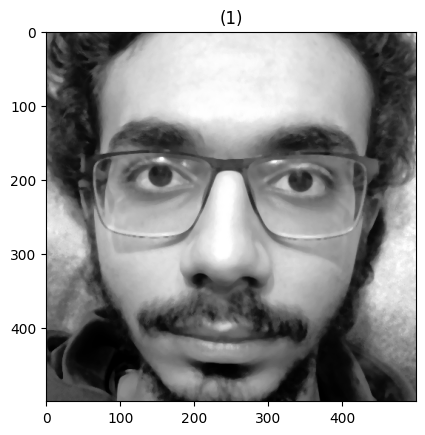

In [5]:
show_images([mssImages[0]])

In [6]:
abdelattyImages = process('../Data/ourDataset/cropped/Abdelatty/',
                    rem_noise=True, gamma_corre=True, hist_eq=True,resize=True,target_size=target_image_size,gamma=0.8)

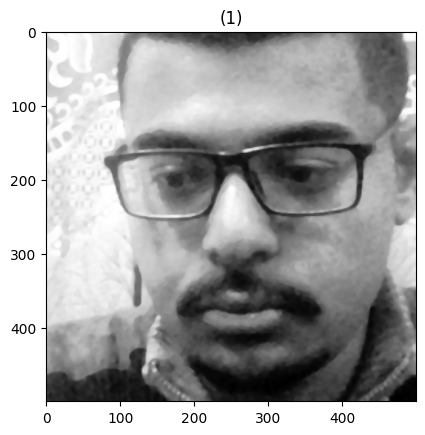

In [7]:
show_images([abdelattyImages[0]])

In [8]:
ismailImages = process('../Data/ourDataset/cropped/Ismail/',
                    rem_noise=True, hist_eq=True,resize=True,target_size=target_image_size)

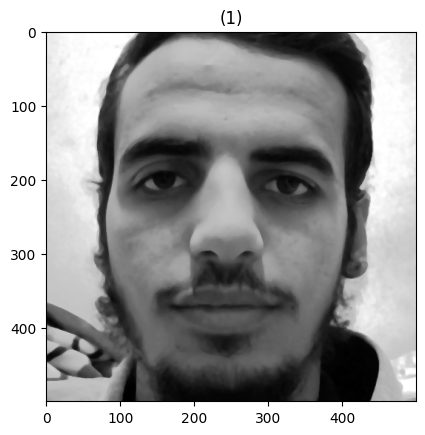

In [9]:
show_images([ismailImages[0]])

In [10]:
hogMss: list[np.ndarray] = get_feature_list_from_paths(mssImages)

In [11]:
hogAbdelatty: list[np.ndarray]= get_feature_list_from_paths(abdelattyImages)

In [12]:
hogIsmail: list[np.ndarray] = get_feature_list_from_paths(ismailImages)

In [13]:
final_hog=hogMss+hogAbdelatty+hogIsmail

In [14]:
first_value = 0 #samir
second_value = 1 #abdelatty
third_value = 2 #ismail


targets_hog = [first_value] * len(hogMss) + [second_value] * len(hogAbdelatty)+[third_value]*len(hogIsmail)

In [15]:
def ComputeLBP(x, y, arr):
    f = s = -1
    value = 0
    height, width = arr.shape
    for i in range(8):
        if (i == 3 or i == 7):
            f = 0
        elif (i > 3):
            f = 1
        if (i == 1 or i == 5):
            s = 0
        elif (i > 1 and i < 5):
            s = 1
        else:
            s = -1
        if (x+f > -1 and x+f < height and y+s > -1 and y+s < width):
            value += pow(2, 7-i) if arr[x+f, y+s] > arr[x, y] else 0
    return value


def LBP(arr):
    tempArr = np.copy(arr)
    hight, width = tempArr.shape
    for i in range(hight):
        for j in range(width):
            tempArr[i, j] = ComputeLBP(i, j, tempArr)
    return tempArr


def get_LBP_features(imagesList):
    imList=[]
    for image,index in zip(imagesList,range(len(imagesList))):
        imList.append(LBP(image)/255)
        print(index)

    return imList

In [16]:
lbp_mss=get_LBP_features(mssImages)
lbp_abdelatty=get_LBP_features(abdelattyImages)
lbp_ismail=get_LBP_features(ismailImages)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [17]:
first_value = 0  # samir
second_value = 1  # abdelatty
third_value = 2  # ismail

final_lbp = lbp_mss+lbp_abdelatty+lbp_ismail
targets_lbp = [first_value] * len(lbp_mss) + [second_value] * len(lbp_abdelatty)+[third_value]*len(lbp_ismail)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from tensorflow import keras

In [19]:
classifiers = {
    'SVM': SVC(random_state=40,kernel='poly'),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'rnd': RandomForestClassifier(random_state=40),
    'voting_clf_soft' : VotingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=7)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42,probability=True))
    ],
    voting='soft'), 
    'voting_clf_hard': VotingClassifier(
    estimators=[
            ('KNN', KNeighborsClassifier(n_neighbors=7)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('svc', SVC(random_state=42))
        ],
    voting='hard'),
    
}

In [20]:
from sklearn.metrics import confusion_matrix
import copy


def train_model(x,y,testSize):
    models=[]

    X_train, X_test, y_train, y_test=train_test_split(x, y,test_size=testSize,stratify=y)

    for model_name, model in copy.deepcopy(classifiers).items():
        
        print('############## Training', model_name, "##############")
        model.fit(X_train, y_train)

        accuracy = model.score(X_test, y_test)

        models.append({model_name:model})

        print(model_name, 'accuracy:', accuracy*100, '%')
        y_pred = model.predict(X_test)

        mat = confusion_matrix(y_test, y_pred)

        print(mat)
            

    return models

In [46]:
final_lbp=[np.ravel(i) for i in final_lbp]

In [22]:
models_hog=train_model(final_hog,targets_hog,0.2)

############## Training SVM ##############
SVM accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training KNN ##############
KNN accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training rnd ##############
rnd accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_soft ##############
voting_clf_soft accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_hard ##############
voting_clf_hard accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]


In [23]:
models_lbp = train_model(final_lbp, targets_lbp, 0.2)

############## Training SVM ##############
SVM accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training KNN ##############
KNN accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training rnd ##############
rnd accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_soft ##############
voting_clf_soft accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_hard ##############
voting_clf_hard accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]


In [24]:
models_lbp

[{'SVM': SVC(kernel='poly', random_state=40)},
 {'KNN': KNeighborsClassifier(n_neighbors=7)},
 {'rnd': RandomForestClassifier(random_state=40)},
 {'voting_clf_soft': VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=7)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   voting='soft')},
 {'voting_clf_hard': VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=7)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(random_state=42))])}]

In [25]:
final=[]

for l,h in zip(final_lbp,final_hog):
    final.append(np.concatenate([l,h],axis=0))

In [26]:
final_models=train_model(final,targets_hog,0.2)

############## Training SVM ##############
SVM accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training KNN ##############
KNN accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training rnd ##############
rnd accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_soft ##############
voting_clf_soft accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]
############## Training voting_clf_hard ##############
voting_clf_hard accuracy: 100.0 %
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 10]]


In [27]:
final_models

[{'SVM': SVC(kernel='poly', random_state=40)},
 {'KNN': KNeighborsClassifier(n_neighbors=7)},
 {'rnd': RandomForestClassifier(random_state=40)},
 {'voting_clf_soft': VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=7)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   voting='soft')},
 {'voting_clf_hard': VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=7)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(random_state=42))])}]

In [28]:
import pickle

def save_models(modelsArray,suffix):
    for model in modelsArray:
        pickle.dump(next(iter(model.values())), open(
            f"{next(iter(model.keys()))}_{suffix}.pkl", "wb"))

In [29]:
save_models(models_hog,"hog")
save_models(models_lbp,"lbp")
save_models(final_models,"final")

In [63]:
# X_train, X_test, y_train, y_test = train_test_split(
#     np.array(final_lbp), np.array(targets_lbp), test_size=0.2, stratify=targets_lbp)

In [64]:
# X_train.shape

In [65]:
# X_train[0].shape

In [66]:
# ANN=keras.Sequential([
#     keras.layers.Flatten(input_shape=(1.250000)),
#         keras.layers.Dense(1000,activation='relu'),
#         keras.layers.Dense(128,activation='relu'),
#         keras.layers.Dense(3, activation='softmax')

#     ])

In [67]:
# ANN.compile(optimizer='adam',
#             loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [68]:
# ANN.fit(X_train, y_train, epochs=10, batch_size=10)